### Import Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

### Read Data

In [2]:
train = pd.read_csv('./Data/train.csv',na_filter=False)
val = pd.read_csv('./Data/val.csv',na_filter=False)
test = pd.read_csv('./Data/test.csv',na_filter=False)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43725 entries, 0 to 43724
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       43725 non-null  int64  
 1   host_response_time               43725 non-null  object 
 2   host_response_rate               43725 non-null  object 
 3   host_acceptance_rate             43725 non-null  object 
 4   host_is_superhost                43725 non-null  int64  
 5   host_identity_verified           43725 non-null  int64  
 6   room_type                        43725 non-null  object 
 7   accommodates                     43725 non-null  int64  
 8   bedrooms                         43725 non-null  float64
 9   beds                             43725 non-null  float64
 10  price                            43725 non-null  float64
 11  minimum_nights                   43725 non-null  int64  
 12  maximum_nights    

In [4]:
train.drop(['Unnamed: 0'], axis=1, inplace=True)

#### Split columns into their different types

In [5]:
numeric_columns = []
categorical_columns = []
boolean_columns = ['host_is_superhost', 'host_identity_verified', 'has_license', 'instant_bookable']
ordered_columns = ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'review_scores_rating', 'description_sentiment', 'neighborhood_overview_sentiment']

column_types = train.dtypes
for i in range(len(column_types)):
  if column_types[i] == 'object' and column_types.index[i] not in ordered_columns:
    categorical_columns.append(column_types.index[i])
  elif column_types.index[i] not in boolean_columns and column_types[i] != 'object':
    numeric_columns.append(column_types.index[i])

print("numeric_columns: " + str(numeric_columns))
print("categorical_columns: " + str(categorical_columns))
print("boolean_columns: " + str(boolean_columns))
print("ordered_columns: " + str(ordered_columns))

numeric_columns: ['accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'availability_30', 'number_of_reviews', 'reviews_per_month', 'num_mall_within_1000', 'num_attraction_within_1000', 'sentiment_median_score', 'essentials', 'luxury', 'appliances', 'comfort', 'entertainment', 'security', 'furniture', 'miscellaneous', 'bathrooms']
categorical_columns: ['room_type', 'state', 'host_gender', 'bathroom_type']
boolean_columns: ['host_is_superhost', 'host_identity_verified', 'has_license', 'instant_bookable']
ordered_columns: ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'review_scores_rating', 'description_sentiment', 'neighborhood_overview_sentiment']


In [6]:
train[train.select_dtypes('object').columns].nunique().reset_index(name='cardinality')
val[val.select_dtypes('object').columns].nunique().reset_index(name='cardinality')
test[test.select_dtypes('object').columns].nunique().reset_index(name='cardinality')

,index,cardinality
0,host_response_time,5
1,host_response_rate,7
2,host_acceptance_rate,7
3,room_type,4
4,review_scores_rating,26
5,state,8
6,description_sentiment,6
7,neighborhood_overview_sentiment,7
8,host_gender,3
9,bathroom_type,6


### Checking our target variable

Skewness: 20.256241
Kurtosis: 653.266100


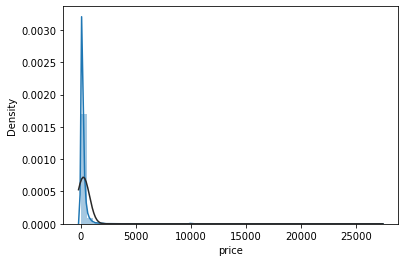

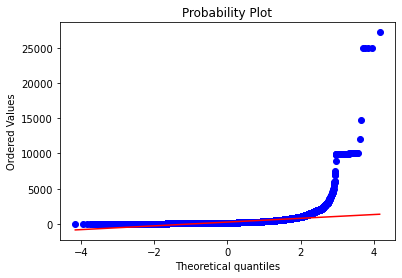

In [7]:
import scipy.stats as stats
from scipy.stats import norm

sns.distplot(train['price'], kde=True,fit=norm);
fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
print("Skewness: %f" % train['price'].skew())
print("Kurtosis: %f" % train['price'].kurt())

###### Clearly, the price variable here is very skewed with its high skewness and kurtosis values. We could try to remove outliers or transform the variable.

In [8]:
q3, q1 = np.percentile(train['price'], [75 ,25])
iqr = q3 - q1
lower_bound = max(q1 - 1.5* iqr, 0)
upper_bound = q3 + 1.5 * iqr
print(lower_bound, upper_bound)

0 518.0


In [9]:
train = train[train['price'] <= 518.0]
train.reset_index(inplace=True)
X_train = train.drop(['price'], axis=1)
y_train = train['price']

val = val[val['price'] <= 518.0]
val.reset_index(inplace=True)
X_val = val.drop(['price'], axis=1)
y_val = val['price']

test = test[test['price'] <= 518.0]
test.reset_index(inplace=True)
X_test = test.drop(['price'], axis=1)
y_test = test['price']

In [10]:
train['price'].max()

518.0

Skewness: 1.120570
Kurtosis: 0.676878


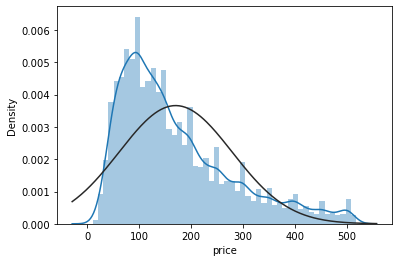

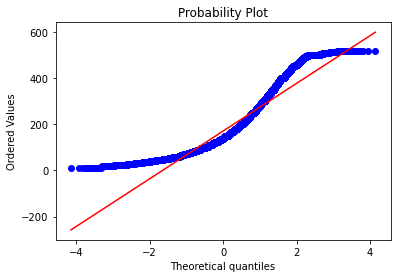

In [11]:
sns.distplot(train['price'], kde=True,fit=norm);
fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
print("Skewness: %f" % train['price'].skew())
print("Kurtosis: %f" % train['price'].kurt())

In [12]:
X_train = train.drop(['price'], axis=1)
y_train = train['price']

X_val = val.drop(['price'], axis=1)
y_val = val['price']

X_test = test.drop(['price'], axis=1)
y_test = test['price']

### Handling Categorical Variables

In [13]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

enc_X_train = pd.DataFrame()
enc_X_val = pd.DataFrame()
enc_X_test = pd.DataFrame()
enc_X_combined_test = pd.DataFrame()

for column in X_train.columns:
  if column in categorical_columns:
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_col_train = enc.fit_transform(X_train[[column]])
    feature_names = enc.get_feature_names_out()
    enc_X_train[feature_names] = pd.DataFrame.sparse.from_spmatrix(enc_col_train, columns=feature_names)

    enc_col_val = enc.transform(X_val[[column]])
    enc_X_val[feature_names] = pd.DataFrame.sparse.from_spmatrix(enc_col_val, columns=feature_names)

    enc_col_test = enc.transform(X_test[[column]])
    enc_X_test[feature_names] = pd.DataFrame.sparse.from_spmatrix(enc_col_test, columns=feature_names)
  elif column in numeric_columns:
    scaler = StandardScaler()
    transformed_col_train = scaler.fit_transform(X_train[[column]])
    enc_X_train[column] = transformed_col_train

    transformed_col_val = scaler.transform(X_val[[column]])
    enc_X_val[column] = transformed_col_val

    transformed_col_test = scaler.transform(X_test[[column]])
    enc_X_test[column] = transformed_col_test
  elif column in boolean_columns:
    enc_X_train[column] = X_train[[column]]
    enc_X_val[column] = X_val[[column]]
    enc_X_test[column] = X_test[[column]]

for column in ordered_columns:
    enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    enc_col_train = enc.fit_transform(X_train[[column]])
    enc_X_train[column] = enc_col_train

    enc_col_val = enc.transform(X_val[[column]])
    enc_X_val[column] = enc_col_val
    
    enc_col_test = enc.transform(X_test[[column]])
    enc_X_test[column] = enc_col_test

In [14]:
enc_X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40140 entries, 0 to 40139
Data columns (total 51 columns):
 #   Column                           Non-Null Count  Dtype             
---  ------                           --------------  -----             
 0   host_is_superhost                40140 non-null  int64             
 1   host_identity_verified           40140 non-null  int64             
 2   room_type_Entire home/apt        40140 non-null  Sparse[float64, 0]
 3   room_type_Hotel room             40140 non-null  Sparse[float64, 0]
 4   room_type_Private room           40140 non-null  Sparse[float64, 0]
 5   room_type_Shared room            40140 non-null  Sparse[float64, 0]
 6   accommodates                     40140 non-null  float64           
 7   bedrooms                         40140 non-null  float64           
 8   beds                             40140 non-null  float64           
 9   minimum_nights                   40140 non-null  float64           
 10  maximum_ni

## Feature Selection

### Correlation

In [15]:
corr_with_y = enc_X_train.corrwith(y_train)
corr_with_y.sort_values(ascending = False)

accommodates                       0.625897
bedrooms                           0.624567
beds                               0.547853
bathroom_type_baths                0.547407
room_type_Entire home/apt          0.453123
bathrooms                          0.373818
entertainment                      0.269810
appliances                         0.260054
luxury                             0.227750
miscellaneous                      0.225600
furniture                          0.136509
has_license                        0.126966
description_sentiment              0.120100
availability_30                    0.117573
host_response_time                 0.113138
sentiment_median_score             0.111822
essentials                         0.104063
state_Santa Cruz County            0.099398
state_San Diego                    0.081488
instant_bookable                   0.067897
review_scores_rating               0.067686
host_is_superhost                  0.065152
comfort                         

##### None of them have a correlation of 0, so we can keep them

### RFE

The Recursive Feature Elimination (RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses accuracy metric to rank the feature according to their importance. 

In [17]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

#no of features
nof_list=np.arange(1,51)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(enc_X_train,y_train)
    X_test_rfe = rfe.transform(enc_X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 48
Score with 48 features: 0.543806


In [18]:
cols = list(enc_X_train.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, n_features_to_select = 48)

#Transforming data using RFE
X_rfe = rfe.fit_transform(enc_X_train, y_train)  

#Fitting the data to model
model.fit(X_rfe, y_train)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['host_is_superhost', 'host_identity_verified',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room', 'accommodates',
       'bedrooms', 'beds', 'minimum_nights', 'availability_30',
       'number_of_reviews', 'instant_bookable', 'reviews_per_month',
       'state_Los Angeles', 'state_Oakland', 'state_Pacific Grove',
       'state_San Diego', 'state_San Francisco', 'state_San Mateo County',
       'state_Santa Clara County', 'state_Santa Cruz County',
       'num_mall_within_1000', 'num_attraction_within_1000',
       'sentiment_median_score', 'has_license', 'essentials', 'luxury',
       'appliances', 'comfort', 'entertainment', 'furniture', 'miscellaneous',
       'host_gender_female', 'host_gender_male', 'host_gender_unknown',
       'bathrooms', 'bathroom_type_NA', 'bathroom_type_bath',
       'bathroom_type_baths', 'bathroom_type_half-bath',
       'bathroom_type_private', 'bathroom_type_shared', 'host_response_

In [19]:
X_train_rfe = enc_X_train[list(selected_features_rfe)]
X_test_rfe = enc_X_test[list(selected_features_rfe)]
X_val_rfe = enc_X_val[list(selected_features_rfe)]

### Embedded Method

Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.

Here we will do feature selection using Lasso regularization. If the feature is irrelevant, lasso penalizes it’s coefficient and make it 0. Hence the features with coefficient = 0 are removed and the rest are taken.

In [20]:
from sklearn.linear_model import LassoCV

reg = LassoCV()
reg.fit(enc_X_train, y_train)

print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(enc_X_train,y_train))

coef = pd.Series(reg.coef_, index = enc_X_train.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Best alpha using built-in LassoCV: 0.127818
Best score using built-in LassoCV: 0.560607
Lasso picked 43 variables and eliminated the other 8 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

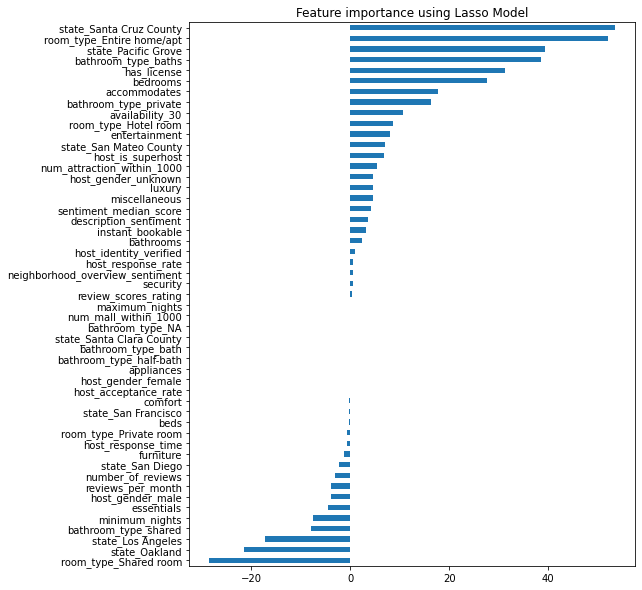

In [21]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [22]:
selected_features_lasso = imp_coef[imp_coef != 0].index
selected_features_lasso

Index(['room_type_Shared room', 'state_Oakland', 'state_Los Angeles',
       'bathroom_type_shared', 'minimum_nights', 'essentials',
       'host_gender_male', 'reviews_per_month', 'number_of_reviews',
       'state_San Diego', 'furniture', 'host_response_time',
       'room_type_Private room', 'beds', 'state_San Francisco', 'comfort',
       'host_acceptance_rate', 'review_scores_rating', 'security',
       'neighborhood_overview_sentiment', 'host_response_rate',
       'host_identity_verified', 'bathrooms', 'instant_bookable',
       'description_sentiment', 'sentiment_median_score', 'miscellaneous',
       'luxury', 'host_gender_unknown', 'num_attraction_within_1000',
       'host_is_superhost', 'state_San Mateo County', 'entertainment',
       'room_type_Hotel room', 'availability_30', 'bathroom_type_private',
       'accommodates', 'bedrooms', 'has_license', 'bathroom_type_baths',
       'state_Pacific Grove', 'room_type_Entire home/apt',
       'state_Santa Cruz County'],
      d

In [23]:
X_train_lasso = enc_X_train[list(selected_features_lasso)]
X_test_lasso = enc_X_test[list(selected_features_lasso)]
X_val_lasso = enc_X_val[list(selected_features_lasso)]

## Linear Regression

### Full set of features

#### Training

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

lin_reg = LinearRegression()
lin_reg.fit(enc_X_train, y_train)

linear_predictions_train = lin_reg.predict(enc_X_train)

lin_mse_train = mean_squared_error(y_train, linear_predictions_train)
lin_rmse_train = np.sqrt(lin_mse_train)
print("Training RMSE for Linear Regression:", lin_rmse_train)

lin_mae_train = mean_absolute_error(y_train, linear_predictions_train)
print("Training MAE for Linear Regression:", lin_mae_train)

lin_r2_train = r2_score(y_train, linear_predictions_train)
print("Training R2 for Linear Regression:", lin_r2_train)

Training RMSE for Linear Regression: 72.20783717660493
Training MAE for Linear Regression: 52.16235343485302
Training R2 for Linear Regression: 0.5610191660182364


#### Validation

In [25]:
linear_predictions_val = lin_reg.predict(enc_X_val)

lin_mse_val = mean_squared_error(y_val, linear_predictions_val)
lin_rmse_val = np.sqrt(lin_mse_val)
print("Validation RMSE for Linear Regression:", lin_rmse_val)

lin_mae_val = mean_absolute_error(y_val, linear_predictions_val)
print("Validation MAE for Linear Regression:", lin_mae_val)

lin_r2_val = r2_score(y_val, linear_predictions_val)
print("Validation R2 for Linear Regression:", lin_r2_val)

Validation RMSE for Linear Regression: 71.64465038033893
Validation MAE for Linear Regression: 52.45043209572582
Validation R2 for Linear Regression: 0.5640498267537478


### Features after RFE

#### Training

In [26]:
lin_reg_rfe = LinearRegression()

lin_reg_rfe.fit(X_train_rfe, y_train)

rfe_predictions_train = lin_reg_rfe.predict(X_train_rfe)

rfe_mse_train = mean_squared_error(y_train, rfe_predictions_train)
rfe_rmse_train = np.sqrt(rfe_mse_train)
print("Training RMSE for Linear Regression:", rfe_rmse_train)

rfe_mae_train = mean_absolute_error(y_train, rfe_predictions_train)
print("Training MAE for Linear Regression:", rfe_mae_train)

rfe_r2_train = r2_score(y_train, rfe_predictions_train)
print("Training R2 for Linear Regression:", rfe_r2_train)

Training RMSE for Linear Regression: 72.14148953746154
Training MAE for Linear Regression: 52.095270305882536
Training R2 for Linear Regression: 0.5618255040086613


#### Validation

In [29]:
rfe_predictions_val = lin_reg_rfe.predict(X_val_rfe)

rfe_mse_val = mean_squared_error(y_val, rfe_predictions_val)
rfe_rmse_val = np.sqrt(rfe_mse_val)
print("Validation RMSE for Linear Regression:", rfe_rmse_val)

rfe_mae_val = mean_absolute_error(y_val, rfe_predictions_val)
print("Validation MAE for Linear Regression:", rfe_mae_val)

rfe_r2_val = r2_score(y_val, rfe_predictions_val)
print("Validation R2 for Linear Regression:", rfe_r2_val)

Validation RMSE for Linear Regression: 71.50808575982289
Validation MAE for Linear Regression: 52.31403841774178
Validation R2 for Linear Regression: 0.565710205535124


### Features after LassoCV

#### Training

In [30]:
lin_reg_lasso = LinearRegression()

lin_reg_lasso.fit(X_train_lasso, y_train)

lasso_predictions_train = lin_reg_lasso.predict(X_train_lasso)

lasso_mse_train = mean_squared_error(y_train, lasso_predictions_train)
lasso_rmse_train = np.sqrt(lasso_mse_train)
print("Training RMSE for Linear Regression:", lasso_rmse_train)

lasso_mae_train = mean_absolute_error(y_train, lasso_predictions_train)
print("Training MAE for Linear Regression:", lasso_mae_train)

lasso_r2_train = r2_score(y_train, lasso_predictions_train)
print("Training R2 for Linear Regression:", lasso_r2_train)

Training RMSE for Linear Regression: 72.14294874958892
Training MAE for Linear Regression: 52.1126376486162
Training R2 for Linear Regression: 0.5618077778427877


#### Validation

In [31]:
lin_reg_lasso.fit(X_val_lasso, y_val)

lasso_predictions_val = lin_reg_lasso.predict(X_val_lasso)

lasso_mse_val = mean_squared_error(y_val, lasso_predictions_val)
lasso_rmse_val = np.sqrt(lasso_mse_train)
print("Validation RMSE for Linear Regression:", lasso_rmse_val)

lasso_mae_val = mean_absolute_error(y_val, lasso_predictions_val)
print("Validation MAE for Linear Regression:", lasso_mae_val)

lasso_r2_val = r2_score(y_val, lasso_predictions_val)
print("Validation R2 for Linear Regression:", lasso_r2_val)

Validation RMSE for Linear Regression: 72.14294874958892
Validation MAE for Linear Regression: 51.89988551309828
Validation R2 for Linear Regression: 0.5710094492003899


##### It seems like the model after feature selection using LassoCV is the best. We'll go ahead to test this model

## Predict

In [32]:
y_pred = lin_reg_lasso.predict(X_test_lasso)
print("score: ",lin_reg_lasso.score(X_test_lasso,y_test))
print("Model slope:    ", lin_reg_lasso.coef_)
print("Model intercept:", lin_reg_lasso.intercept_)

score:  0.5436628558328367
Model slope:     [ 1.34835978e+14 -2.98598148e+01 -2.27978474e+01  5.76502995e+00
 -5.82119197e+00 -3.92669006e+00 -4.50307215e+00 -1.48517272e+00
 -4.32780461e+00 -8.22552231e+00 -1.32539800e+00 -2.34566130e+00
  1.34835978e+14  4.09801225e+00 -5.72258854e+00 -2.72540985e+00
 -1.23148611e+00  6.55485840e-01  1.11770348e-01  1.37287607e+00
  1.51786712e-01  5.14119997e+00  3.66200828e+00  3.70192885e+00
  4.23497685e+00  5.00707741e+00  2.90542320e+00  4.96019139e+00
  3.68378346e+00  5.45676216e+00  9.46495768e+00  5.22098554e+00
  9.49141497e+00  1.34835978e+14  1.26193681e+01  3.14817056e+01
  1.29553492e+01  2.79584577e+01  3.12450875e+01  3.60901684e+01
  1.01087937e+01  1.34835978e+14  6.00961863e+01]
Model intercept: -134835977670688.89


In [36]:
final_mse = mean_squared_error(y_test, y_pred)
final_rmse = np.sqrt(final_mse)
print("Validation RMSE for Linear Regression:", final_rmse)

final_mae = mean_absolute_error(y_test, y_pred)
print("Validation MAE for Linear Regression:", final_mae)

final_r2 = r2_score(y_test, y_pred)
print("Validation R2 for Linear Regression:", final_r2)

Validation RMSE for Linear Regression: 74.35191808462486
Validation MAE for Linear Regression: 53.34575783885691
Validation R2 for Linear Regression: 0.5436628558328367


In [35]:
y_pred_base = lin_reg.predict(enc_X_test)
print("score: ",lin_reg.score(enc_X_test,y_test))
print("Model slope:    ", lin_reg_lasso.coef_)
print("Model intercept:", lin_reg_lasso.intercept_)

score:  0.5411017306804267
Model slope:     [ 1.34835978e+14 -2.98598148e+01 -2.27978474e+01  5.76502995e+00
 -5.82119197e+00 -3.92669006e+00 -4.50307215e+00 -1.48517272e+00
 -4.32780461e+00 -8.22552231e+00 -1.32539800e+00 -2.34566130e+00
  1.34835978e+14  4.09801225e+00 -5.72258854e+00 -2.72540985e+00
 -1.23148611e+00  6.55485840e-01  1.11770348e-01  1.37287607e+00
  1.51786712e-01  5.14119997e+00  3.66200828e+00  3.70192885e+00
  4.23497685e+00  5.00707741e+00  2.90542320e+00  4.96019139e+00
  3.68378346e+00  5.45676216e+00  9.46495768e+00  5.22098554e+00
  9.49141497e+00  1.34835978e+14  1.26193681e+01  3.14817056e+01
  1.29553492e+01  2.79584577e+01  3.12450875e+01  3.60901684e+01
  1.01087937e+01  1.34835978e+14  6.00961863e+01]
Model intercept: -134835977670688.89


In [37]:
final_mse_base = mean_squared_error(y_test, y_pred_base)
final_rmse_base = np.sqrt(final_mse_base)
print("Validation RMSE for Linear Regression:", final_rmse_base)

final_mae_base = mean_absolute_error(y_test, y_pred_base)
print("Validation MAE for Linear Regression:", final_mae_base)

final_r2_base = r2_score(y_test, y_pred_base)
print("Validation R2 for Linear Regression:", final_r2_base)

Validation RMSE for Linear Regression: 74.56027076272048
Validation MAE for Linear Regression: 53.51391651369319
Validation R2 for Linear Regression: 0.5411017306804267
